# Hello, I'm Nadim
An undergraduate student at the **Department of Oceanography**.

Shahjalal University of Science and Technology, Sylhet.

If you have any query, don't hesitate to contact me.👇🏻

**Email:** nadimrahman087@gmail.com

<li><a href="https://www.linkedin.com/in/nadim87" target="_blank"><i class="fab fa-linkedin"></i> LinkedIn</a></li>





I suffered a lot with hdf4 datasets. There are tools that can be used to read and create maps from this type of file, but you have to do it one by one. You can also automate using GDAL with hdf4 driver enabled but that's painful to compile. As a lazy person, I needed a Pythonic way to convert it into an xarray with proper Coordinate System. It took a while😮‍💨,but I finally made it. 😌✌🏻

The **pyhdf** library must be installed on your python environment.

# Let's Start Coding.

**Importing necessary Libraries**

In [1]:
import pandas as pd
from pyhdf.SD import SD,SDC
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray
import numpy as np
import matplotlib_scalebar.scalebar as mpl_scalebar
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import seaborn as sns



Loading Shapefile

<Axes: >

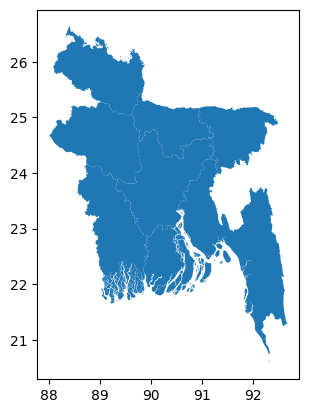

In [2]:
bd = gpd.read_file('/home/nadim/hdf2xarray/bd.shp')
bd.plot()


Reading hdf4 file and printing all the available variables present in the file.

In [2]:
data = SD('/home/nadim/hdf2xarray/MOD11C1/2023/114/MOD11C1.A2023114.061.2023115214630.hdf')
for i in data.datasets():
    print(i)

LST_Day_CMG
QC_Day
Day_view_time
Day_view_angl
LST_Night_CMG
QC_Night
Night_view_time
Night_view_angl
Emis_20
Emis_22
Emis_23
Emis_29
Emis_31
Emis_32
Emis_20_night
Emis_22_night
Emis_23_night
Emis_29_night
QC_Emis
QC_Emis_night
Percent_land_in_grid


Selecting and printing the necessary information about the desired variable👇🏼.

In [3]:
print(data.datasets()['LST_Day_CMG'])
data.select('LST_Day_CMG').attributes()


(('YDim:MODIS_CMG_3MIN_LST', 'XDim:MODIS_CMG_3MIN_LST'), (3600, 7200), 23, 0)


{'long_name': 'Daily daytime 3min CMG Land-surface Temperature',
 'units': 'K',
 'Number Type': 'uint16',
 'valid_range': [7500, 65535],
 '_FillValue': 0,
 'LST': 'LST data * scale_factor',
 'scale_factor': 0.02,
 'scale_factor_err': 0.0,
 'add_offset': 0.0,
 'add_offset_err': 0.0,
 'calibrated_nt': 0}

Ploting Night and Day time LST side by side👇🏼.

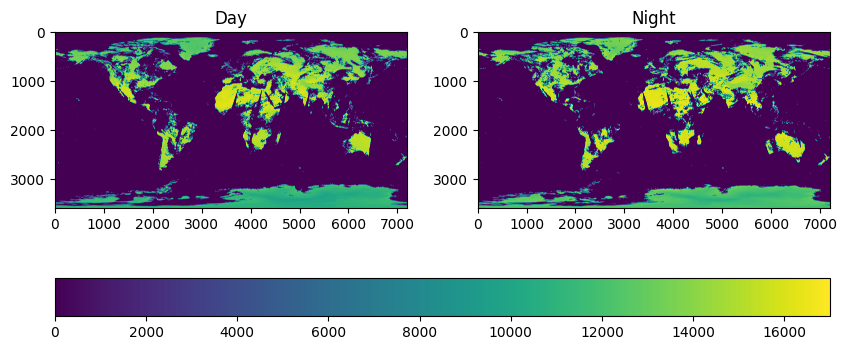

In [6]:

fig, axs = plt.subplots(1, 2,figsize=(10,6))

img_day = axs[0].imshow(data.select('LST_Day_CMG').get())
axs[0].set_title('Day')

img_night = axs[1].imshow(data.select('LST_Night_CMG').get())
axs[1].set_title('Night')

fig.colorbar(img_day, ax=axs, orientation='horizontal')

plt.show()


# Extracting metadata information 👇🏼.

In [ ]:
print(data.attributes())
"""I removed this output, because it's taking a lot of space for visualizing on github.
But you can print it on your notebook without any problem."""

In [7]:
meta_info = data.attributes()
meta_info_str = str(meta_info['StructMetadata.0'])

start_index = meta_info_str.find("GROUP=GRID_1") + len("GROUP=GRID_1")

end_index = meta_info_str.find("END_GROUP=Dimension", start_index)

# Extracting the desired section
required_info = meta_info_str[start_index:end_index]

print(required_info)


		GridName="MODIS_CMG_3MIN_LST"
		XDim=7200
		YDim=3600
		UpperLeftPointMtrs=(-180000000.000000,90000000.000000)
		LowerRightMtrs=(180000000.000000,-90000000.000000)
		Projection=GCTP_GEO
		GridOrigin=HDFE_GD_UL
		GROUP=Dimension
		


# Creating Grids

Assuming the dataset covers the entire globe. *If it does not cover the whole earth then the following code will need to be changed accordingly.*

The MODIS Sinusoidal projection is centered on the equator and wraps around the Earth longitudinally.
Therefore, the longitude ranges from -180 to 180 degrees, and latitude from -90 to 90 degrees


In [8]:

x_dim = 7200  # Number of pixels along the x-axis
y_dim = 3600  # Number of pixels along the y-axis
resolution_degrees = 0.05  # Resolution of the dataset in degrees

# Calculate the pixel size in degrees
pixel_size_degrees = resolution_degrees

# Initialize arrays to hold latitude and longitude values for each pixel
latitudes = np.zeros(y_dim)
longitudes = np.zeros(x_dim)

# Calculate latitudes and longitudes for each pixel
for y in range(y_dim):
    # Latitude decreases as you move down rows (increase y)
    latitudes[y] = 90 - y * pixel_size_degrees

for x in range(x_dim):
    # Longitude increases as you move across columns (increase x)
    longitudes[x] = -180 + x * pixel_size_degrees

# Create a meshgrid for visualization or further processing
X, Y = np.meshgrid(longitudes, latitudes)


# Extracting required variable from data.

In [9]:
lst_day = data.select('LST_Day_CMG')[:]*0.02
print('Maximum Temp. in Kelvin :',lst_day.max())
print('Minimum Temp. in Kelvin :',lst_day.min())

Maximum Temp. in Kelvin : 339.94
Minimum Temp. in Kelvin : 0.0


In [10]:
# Create a DataArray for LST with latitudes and longitudes as coordinates
lst_array = xr.DataArray(
    data=lst_day,
    dims=['latitude', 'longitude'],
    coords={'latitude': ('latitude', latitudes), 'longitude': ('longitude', longitudes)}
)
lst_dataset = xr.Dataset({'LST': lst_array})
lst_dataset

<xarray.Dataset> Size: 207MB
Dimensions:    (latitude: 3600, longitude: 7200)
Coordinates:
  * latitude   (latitude) float64 29kB 90.0 89.95 89.9 ... -89.85 -89.9 -89.95
  * longitude  (longitude) float64 58kB -180.0 -179.9 -179.9 ... 179.9 180.0
Data variables:
    LST        (latitude, longitude) float64 207MB 0.0 0.0 0.0 ... 0.0 0.0 0.0

hdf4 to xarray conversion successful👆🏼.

In [11]:
lst_dataset['LST'] = lst_dataset['LST']-273.15   #Converting to Celsius from Kelvin
lst_dataset

<xarray.Dataset> Size: 207MB
Dimensions:    (latitude: 3600, longitude: 7200)
Coordinates:
  * latitude   (latitude) float64 29kB 90.0 89.95 89.9 ... -89.85 -89.9 -89.95
  * longitude  (longitude) float64 58kB -180.0 -179.9 -179.9 ... 179.9 180.0
Data variables:
    LST        (latitude, longitude) float64 207MB -273.1 -273.1 ... -273.1

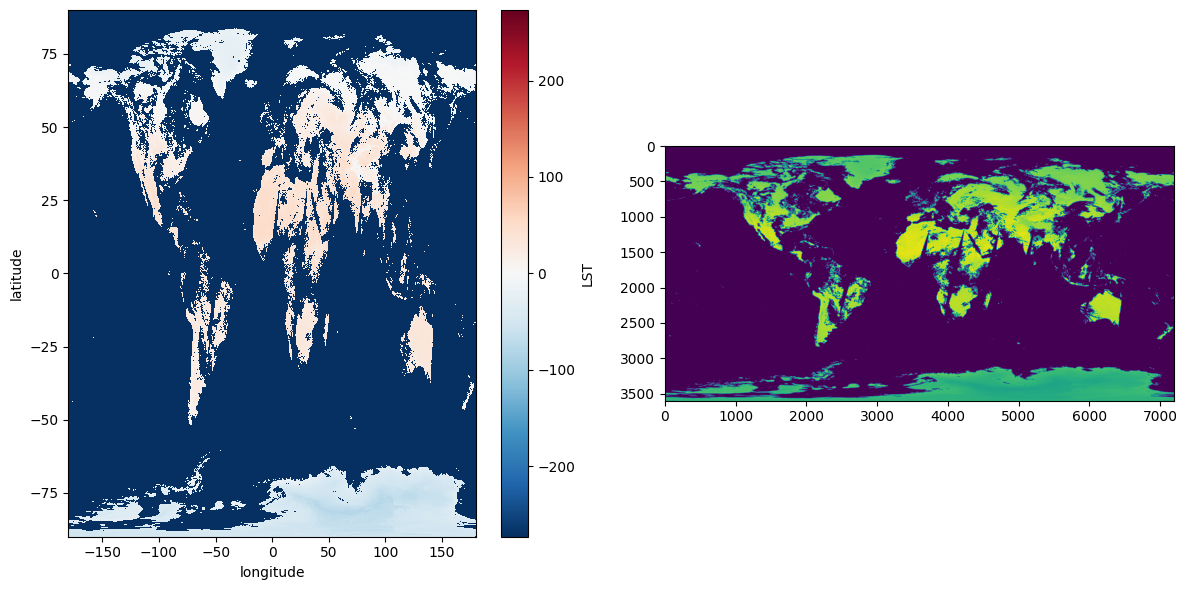

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

lst_dataset['LST'].plot(ax=axs[0])

array_data = data.select('LST_Day_CMG').get()

axs[1].imshow(array_data)

plt.tight_layout()
plt.show()

**Here you can see the x, y axis values are changed into lonigtude and latitude👆🏼.**

# Clipping Bangladesh region.

In [29]:
lst_dataset.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
lst_dataset.rio.write_crs("epsg:4326", inplace=True)
bd_lst = lst_dataset.rio.clip(bd.geometry)
bd_lst['LST'] = bd_lst['LST'].where(bd_lst['LST']!= 0, other=np.nan)
bd_lst

<xarray.Dataset> Size: 89kB
Dimensions:      (latitude: 117, longitude: 93)
Coordinates:
  * latitude     (latitude) float64 936B 26.6 26.55 26.5 ... 20.9 20.85 20.8
  * longitude    (longitude) float64 744B 88.05 88.1 88.15 ... 92.55 92.6 92.65
    spatial_ref  int64 8B 0
Data variables:
    LST          (latitude, longitude) float64 87kB nan nan nan ... nan nan nan

Adding Time dimension as 'Date'.

In [30]:
bd_lst = bd_lst.expand_dims({'Date': pd.to_datetime(['2023-04-24'])})
bd_lst = bd_lst.drop_vars('spatial_ref')
bd_lst


<xarray.Dataset> Size: 89kB
Dimensions:    (Date: 1, latitude: 117, longitude: 93)
Coordinates:
  * Date       (Date) datetime64[ns] 8B 2023-04-24
  * latitude   (latitude) float64 936B 26.6 26.55 26.5 26.45 ... 20.9 20.85 20.8
  * longitude  (longitude) float64 744B 88.05 88.1 88.15 ... 92.55 92.6 92.65
Data variables:
    LST        (Date, latitude, longitude) float64 87kB nan nan nan ... nan nan

And there you go, you have successfully converted an hdf4 file to an xarray✌🏻✌🏻✌🏻.

Now you can save it as netCDF or convert it into a Dataframe and save as csv file.

In [ ]:
bd_lst.to_netcdf('/home/nadim/hdf2xarray/bd_lst.nc')

# Creating Contourf plot.

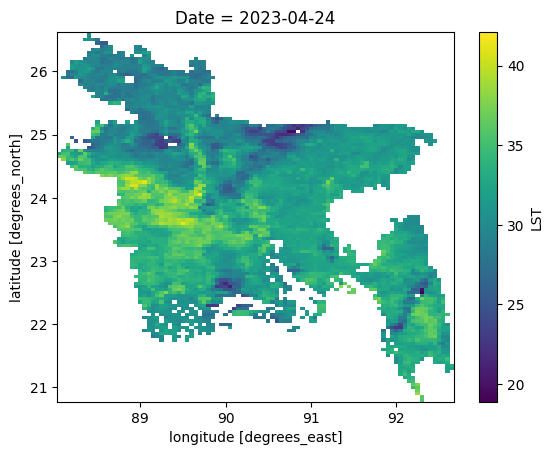

In [31]:
fig, ax = plt.subplots()

bd_lst['LST'].plot(ax=ax)


I don't know why the "contourf" plot was creating upside down plots.

That's why I reversed the latitude orientation. 
If you find out the reason, feel free to notify me😃.

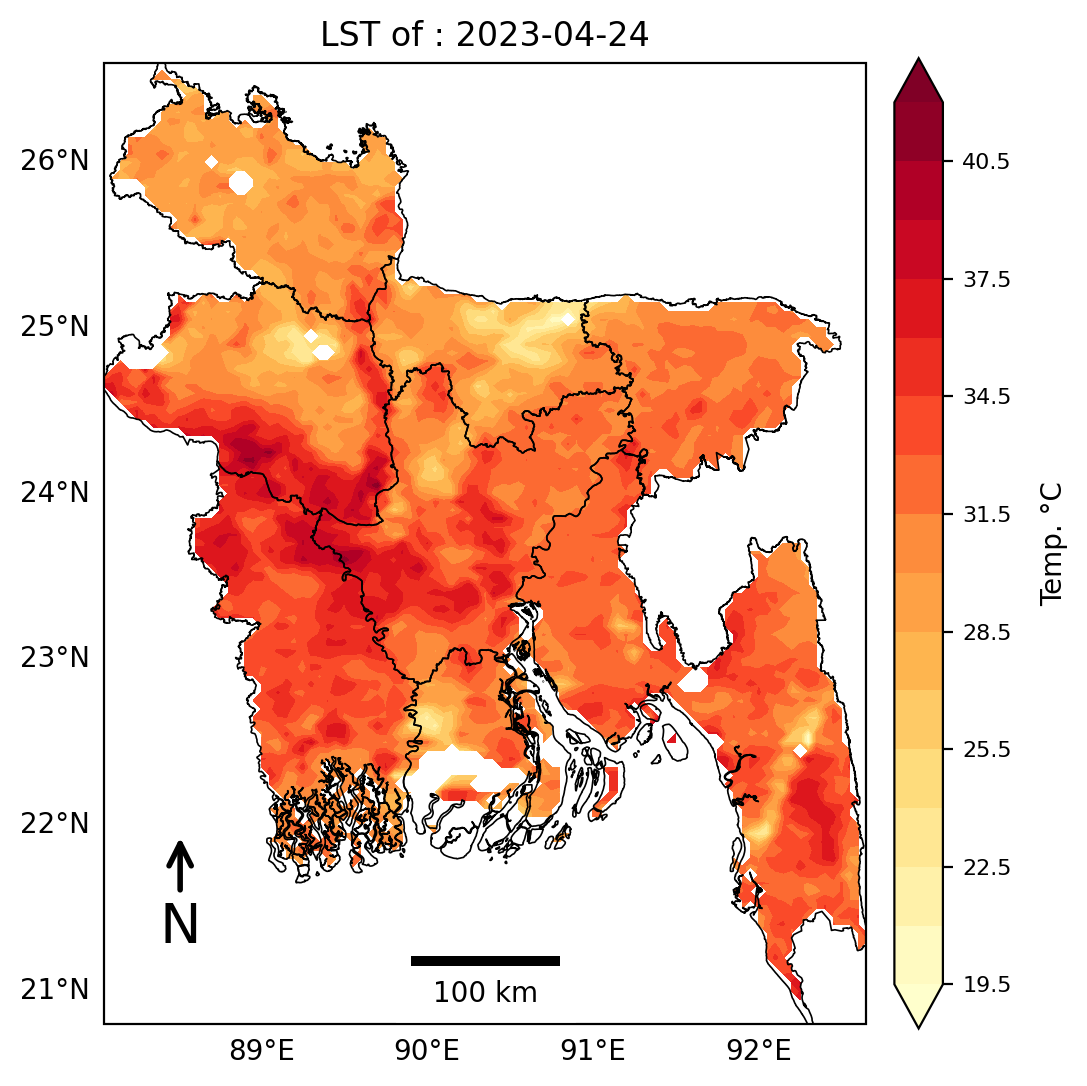

In [46]:
# Creating geoaxis.
fig = plt.figure(figsize=(6,7),dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Adding gridlines with specified properties
gl = ax.gridlines(draw_labels=True, color='gray',
                   linestyle='--', alpha=0.5, x_inline=False, y_inline=False)
gl.top_labels = gl.right_labels = False
gl.xlines = gl.ylines = False

lat = np.linspace(20.8, 26.6, num=117)[::-1]
lon = np.linspace(88.05, 92.65, num=93)
X, Y = np.meshgrid(lon, lat)

# Creating Shaded Map.
cs = ax.contourf(X,Y, bd_lst['LST'].isel(Date=0),levels =20,
                  extend='both', transform=ccrs.PlateCarree(), cmap='YlOrRd')

# Overlaying shapefile.
ax.add_geometries(bd.geometry, ccrs.PlateCarree(),
                   linewidth=0.6, edgecolor='black', facecolor='none')

# Customizing colorbar.
cbar = plt.colorbar(cs, ax=ax, orientation='vertical', pad=0.03, shrink=0.9)
cbar.ax.tick_params(labelsize=8)
cbar.set_label('Temp. °C', rotation=90, labelpad=10)
scalebar_length_km = 111             # 1 degree = 111 km
scalebar = mpl_scalebar.ScaleBar(scalebar_length_km, 'km',
                                  location='lower center', 
                                pad=0.5, box_color='white', box_alpha=0.5)

# Adding North arrow.
ax.annotate('N', xy=(0.1, 0.2), xytext=(0.1, 0.1),
             arrowprops=dict(facecolor='black', edgecolor='black', 
                             arrowstyle='->', lw=2), ha='center',
                               va='center', fontsize=20, 
                               xycoords=ax.transAxes)
plt.title(f"LST of : {bd_lst['Date'].values[0].astype('datetime64[D]').astype(str)}")
ax.add_artist(scalebar)
plt.show()

There's another type of hdf4 file I encounterd, where latitude and longitude values are directly given as a data variable. So, this one is easy to convert. One example is given below.👇🏻

Load dataset and print all variables.

In [4]:
hdf = SD('/home/nadim/hdf2xarray/MOD08_D3.A2000055.061.2017276160246.hdf', SDC.READ)
for i in hdf.datasets():
  print(i)

Solar_Zenith_Mean
Solar_Zenith_Standard_Deviation
Solar_Zenith_Minimum
Solar_Zenith_Maximum
Solar_Zenith_Pixel_Counts
Solar_Azimuth_Mean
Solar_Azimuth_Standard_Deviation
Solar_Azimuth_Minimum
Solar_Azimuth_Maximum
Solar_Azimuth_Pixel_Counts
Sensor_Zenith_Mean
Sensor_Zenith_Standard_Deviation
Sensor_Zenith_Minimum
Sensor_Zenith_Maximum
Sensor_Zenith_Pixel_Counts
Sensor_Azimuth_Mean
Sensor_Azimuth_Standard_Deviation
Sensor_Azimuth_Minimum
Sensor_Azimuth_Maximum
Sensor_Azimuth_Pixel_Counts
Aerosol_Scattering_Angle_Mean
Aerosol_Scattering_Angle_Standard_Deviation
Aerosol_Scattering_Angle_Minimum
Aerosol_Scattering_Angle_Maximum
Aerosol_Scattering_Angle_Pixel_Counts
Aerosol_Scattering_Angle_Histogram_Counts
Aerosol_Avg_Cloud_Distance_Land_Ocean_Mean
Aerosol_Avg_Cloud_Distance_Land_Ocean_Standard_Deviation
Aerosol_Avg_Cloud_Distance_Land_Ocean_Minimum
Aerosol_Avg_Cloud_Distance_Land_Ocean_Maximum
Aerosol_Avg_Cloud_Distance_Land_Ocean_Pixel_Counts
Aerosol_Optical_Depth_Land_Ocean_Mean
Aerosol

👆🏼 There you can see **longitude** and **latitude** are given as **XDim, YDim** respectively.

In [15]:
lons = hdf.select('XDim')[:]
lats = hdf.select('YDim')[:]
water_vapor = hdf.select('Atmospheric_Water_Vapor_Mean')[:]


In [16]:
hdf_array = xr.DataArray(water_vapor, coords=[lats, lons], dims=['lat', 'lon'])
hdf_dataset = xr.Dataset({'water_vapor': hdf_array})
hdf_dataset

<xarray.Dataset> Size: 132kB
Dimensions:      (lat: 180, lon: 360)
Coordinates:
  * lat          (lat) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * lon          (lon) float32 1kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    water_vapor  (lat, lon) int16 130kB 163 159 157 163 151 ... 16 16 16 17 16

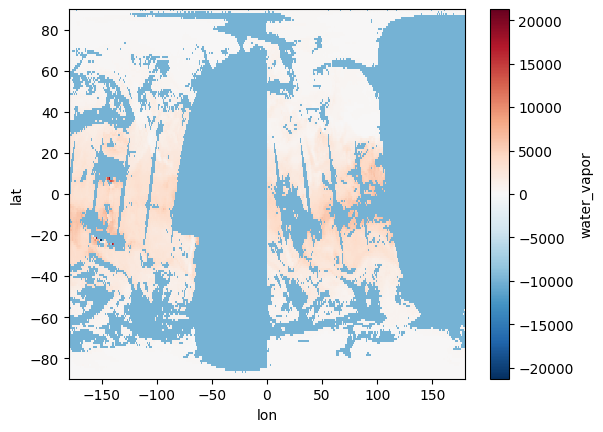

In [17]:
hdf_dataset['water_vapor'].plot()

In [ ]:
hdf_dataset.to_netcdf('/home/nadim/hdf2xarray/water_vapor.nc')

# That's all for now.✌🏻